In [1]:
from fastai.vision import *
import sys

import pose
import models.cs_v2 as cs
%load_ext autoreload
%autoreload 2

In [2]:
root = Path('../../LIP').resolve()
pose_label = pose.LIPLabel(root /'pose_annotations')

In [5]:
transforms = [], None
data = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label))
data

LabelLists;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 447, 635),Image (3, 420, 618),Image (3, 136, 63),Image (3, 358, 279),Image (3, 308, 193)
y: PoseLabelList
Pose (8/16) (447, 635),Pose (7/16) (420, 618),Pose (6/16) (136, 63),Pose (14/16) (358, 279),Pose (1/16) (308, 193)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 261, 315),Image (3, 321, 293),Image (3, 432, 221),Image (3, 168, 53),Image (3, 240, 282)
y: PoseLabelList
Pose (14/16) (261, 315),Pose (16/16) (321, 293),Pose (10/16) (432, 221),Pose (16/16) (168, 53),Pose (10/16) (240, 282)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [43]:
tdata.train[0][0] == data.train[0][0]

True

In [12]:
def get_transforms(do_flip:bool=True, max_rotate:float=10., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = [rand_crop()]
    if do_flip:    res.append(pose.pose_flip_lr(p=1.))
    if max_warp:   res.append(symmetric_warp(magnitude=(-max_warp,max_warp), p=1.))
    if max_rotate: res.append(rotate(degrees=(-max_rotate,max_rotate), p=1.))
    if max_zoom>1: res.append(rand_zoom(scale=(1.,max_zoom), p=1.))
    if max_lighting:
        res.append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=1.))
        res.append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=1.))
    #       train                   , valid
    return (res + listify(xtra_tfms), [crop_pad()])

transforms = get_transforms()
tdata = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=128, resize_method=ResizeMethod.PAD, padding_mode='zeros'))
tdata

LabelLists;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [ ]:
tdata = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=128, resize_method=ResizeMethod.PAD, padding_mode='zeros'))
tdata

In [13]:
transforms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.20792691917181017, 'col_pct': 0.19503416322629819, 'padding_mode': 'reflection'}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (pose_flip_lr), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=1.0, resolved={'magnitude': tensor([ 0.1902,  0.0510,  0.0659, -0.0694]), 'invert': False}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=1.0, resolved={'degrees': 7.3724126680242215}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={'scale': 1.000746527193201, 'row_pct': 0.8896150239176279, 'col_pct': 0.23692199397466174}, 

In [9]:
def show(o):
    x, y = o
    ax = plt.subplot()
    x.show(ax)
    y.show(ax, annotate=True)


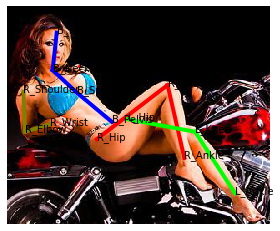

In [20]:
show(data.valid[0])

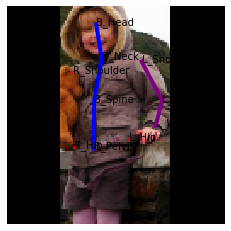

In [11]:
show(tdata.valid[2])

In [19]:
vt = transforms[1]
vt

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=True)]

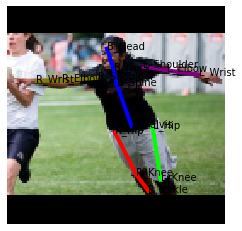

In [18]:
show(tdata.valid[5])

In [ ]:
diff = []
for t, i in zip(tdata.train, data.train):
    if torch.sum(t[1].data[:, 2] > 0).item() != i[1].n_vis:
        diff.append((t, i))

len(diff)

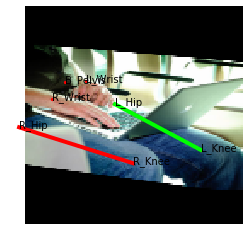

In [21]:
show(t)

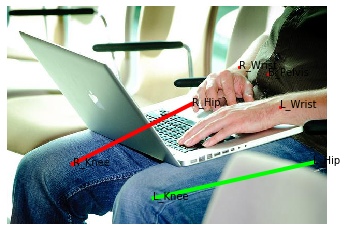

In [22]:
show(i)

In [27]:
diff[0][1][1].visible

tensor([1., 1., 1., 1., 1., 1., 2., 0., 0., 0., 1., 1., 1., 1., 1., 1.])

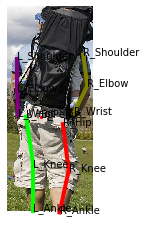

In [23]:
show(diff[0][1])